# 《Masked Autoencoders Are Scalable Vision Learners》

## Architecture
- 参考Bert的MLM范式和ViT的patchify进行自监督学习
- Encoder：ViT-B/16<p>对non-masked patch进行编码，计算消耗少
- Decoder：根据实验选择8 blocks，512 dimensions的mlp block<p>轻量化，参数少
- 预训练完成之后，保留Encoder对不掩码的图像all patches进行特征提取用于下游识别任务

![alt text](<../../Note Image/MAE.png>)

## Pipeline demo

In [1]:
import sys
sys.path.append(r"C:\Users\Lenovo\Desktop\Paper-recover\Self Surpervised Learning\MAE\MAE-meta")
import os
import requests
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import models_mae

In [2]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

In [3]:
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std
img_tensor=torch.from_numpy(img)
#plt.rcParams['figure.figsize'] = [5, 5]
#show_image(torch.tensor(img))

In [7]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
#(!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth)

chkpt_dir = r"G:\code\model\mae_visualize_vit_large.pth"
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_58896\593299904.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, map_location='cpu')


<All keys matched successfully>
Model loaded.


MAE with pixel reconstruction:


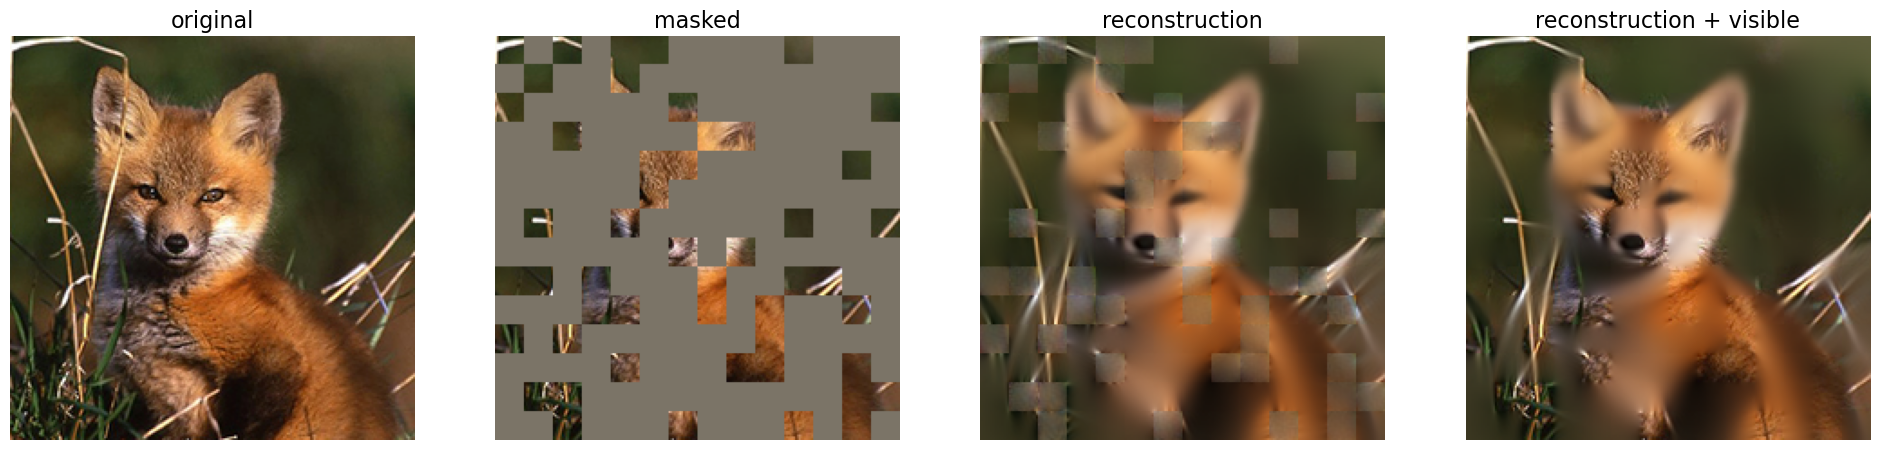

In [8]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(114514)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

# ViT on MAE

- 根据论文中的实验图可见：
    - 自监督方法训练的ViT的ImageNet1k 准确率高于监督方法从0训练的ViT
    - MAE自监督方法相比其他自监督方法在训练ViT有一定的竞争力和优势

![alt text](<../../Note Image/MAE_expreiments.png>)

然而下面的实验表明DINO依然是目前最好用的视觉自监督模型，DINO-VIT的注意力图捕捉的更加好

Using device: cuda
正在加载 ViT-MAE model...
正在加载 DINO ViT-Small model...


Using cache found in C:\Users\Lenovo/.cache\torch\hub\facebookresearch_dino_main


正在处理图片 1/5 使用模型 ViT-MAE-Base...
正在处理图片 1/5 使用模型 DINO-ViT-S...
正在处理图片 2/5 使用模型 ViT-MAE-Base...
正在处理图片 2/5 使用模型 DINO-ViT-S...
正在处理图片 3/5 使用模型 ViT-MAE-Base...
正在处理图片 3/5 使用模型 DINO-ViT-S...
正在处理图片 4/5 使用模型 ViT-MAE-Base...
正在处理图片 4/5 使用模型 DINO-ViT-S...
正在处理图片 5/5 使用模型 ViT-MAE-Base...
正在处理图片 5/5 使用模型 DINO-ViT-S...


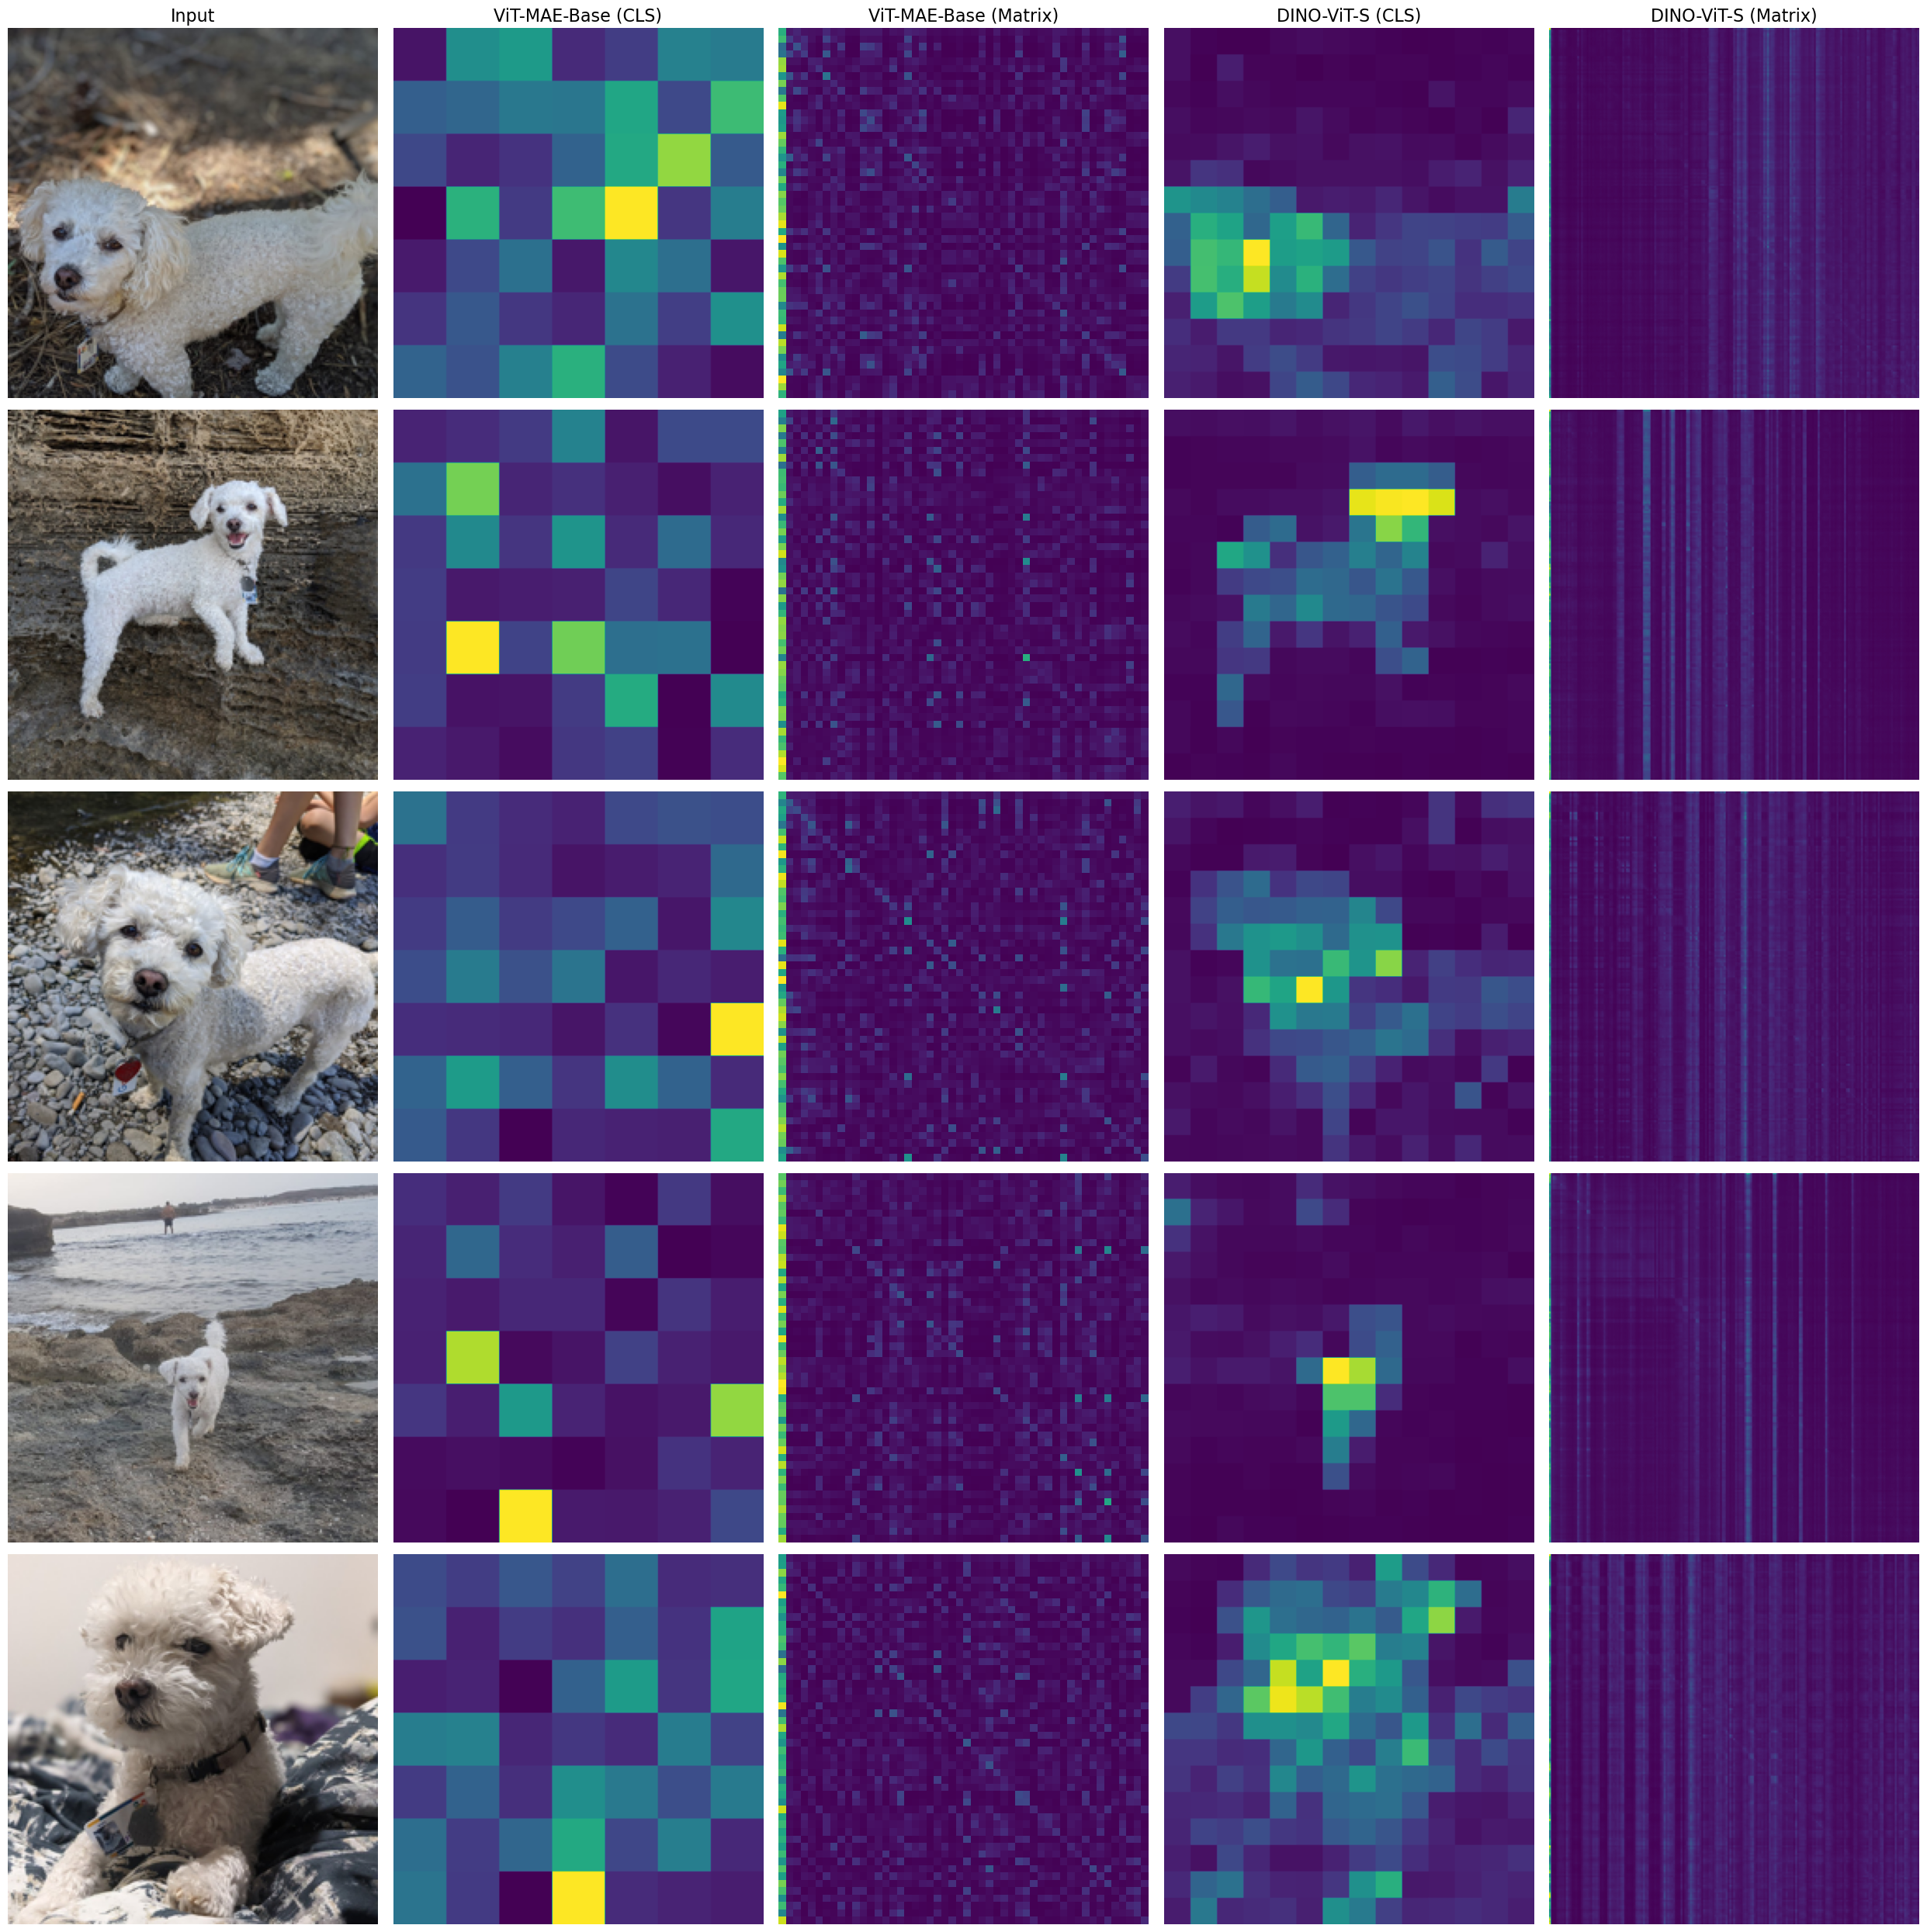

In [2]:
import torch
import torch.nn.functional as F
from transformers import ViTMAEForPreTraining, ViTImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import random

def get_attention_map(model, processor, image, device, model_type='huggingface'):
    """
    为给定的模型和图像生成 [CLS] token 注意力图。
    """
    # 图像预处理
    if model_type == 'huggingface':
        inputs = processor(images=image, return_tensors="pt").to(device)
        pixel_values = inputs.pixel_values
    elif model_type == 'dino':
        pixel_values = processor(image).unsqueeze(0).to(device)
    else:
        raise ValueError("Unsupported model_type")
        
    with torch.no_grad():
        if model_type == 'huggingface':
            outputs = model(pixel_values, output_attentions=True)
            attentions = outputs.attentions[-1]
        elif model_type == 'dino':
            attentions = model.get_last_selfattention(pixel_values)
            
    avg_attentions = attentions.mean(dim=1).squeeze(0)
    cls_attentions = avg_attentions[0, 1:]
    num_patches = cls_attentions.shape[0]
    h = w = int(num_patches ** 0.5)
    attention_map = cls_attentions.reshape(h, w)
    
    resized_map = F.interpolate(
        attention_map.unsqueeze(0).unsqueeze(0),
        size=(image.height, image.width),
        mode="nearest"
    ).squeeze().cpu().numpy()
    
    return resized_map

def get_full_attention_matrix(model, processor, image, device, model_type='huggingface'):
    """
    为给定模型获取最后一个block的、平均后的完整注意力矩阵。
    """
    if model_type == 'huggingface':
        inputs = processor(images=image, return_tensors="pt").to(device)
        pixel_values = inputs.pixel_values
    elif model_type == 'dino':
        pixel_values = processor(image).unsqueeze(0).to(device)
    else:
        raise ValueError("Unsupported model_type")
        
    with torch.no_grad():
        if model_type == 'huggingface':
            outputs = model(pixel_values, output_attentions=True)
            attentions = outputs.attentions[-1]
        elif model_type == 'dino':
            attentions = model.get_last_selfattention(pixel_values)
            
    avg_attentions = attentions.mean(dim=1).squeeze(0)
    return avg_attentions.cpu().numpy()

def generate_comparison_grid(images, models_dict, device):
    """
    为多张图和多个模型生成注意力对比图。
    每张图的布局: [Input, Model1_CLS, Model1_Matrix, Model2_CLS, Model2_Matrix, ...]
    """
    num_images = len(images)
    num_models = len(models_dict)
    
    num_cols = 1 + 2 * num_models
    fig, axes = plt.subplots(num_images, num_cols, figsize=(5 * num_cols, 5 * num_images))
    axes_grid = np.array(axes).reshape(num_images, -1)
    
    col_titles = ['Input']
    for model_name in models_dict.keys():
        col_titles.extend([f"{model_name} (CLS)", f"{model_name} (Matrix)"])

    for ax, title in zip(axes_grid[0], col_titles):
        ax.set_title(title, fontsize=16)

    for i, image in enumerate(images):
        image = image.resize((224, 224))
        current_axes_row = axes_grid[i]
        
        ax_input = current_axes_row[0]
        ax_input.imshow(image)
        ax_input.axis('off')
        
        for j, (model_name, model_info) in enumerate(models_dict.items()):
            print(f"正在处理图片 {i+1}/{num_images} 使用模型 {model_name}...")
            model = model_info['model']
            processor = model_info['processor']
            model_type = model_info['type']
            
            # 1. CLS 注意力图
            cls_attn_map = get_attention_map(model, processor, image, device, model_type=model_type)
            ax_cls = current_axes_row[1 + j * 2]
            ax_cls.imshow(cls_attn_map, cmap='viridis')
            ax_cls.axis('off')

            # 2. 完整注意力矩阵
            full_matrix = get_full_attention_matrix(model, processor, image, device, model_type=model_type)
            ax_matrix = current_axes_row[1 + j * 2 + 1]
            ax_matrix.imshow(full_matrix, cmap='viridis')
            ax_matrix.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    print("正在加载 ViT-MAE model...")
    mae_model = ViTMAEForPreTraining.from_pretrained(r"G:\code\model\vit-mae-base", attn_implementation="eager").to(device)
    mae_processor = ViTImageProcessor.from_pretrained(r"G:\code\model\vit-mae-base", use_fast=True)
    mae_model.eval()

    print("正在加载 DINO ViT-Small model...")
    dino_model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16').to(device)
    dino_model.eval()
    from torchvision import transforms as pth_transforms
    dino_processor = pth_transforms.Compose([
        pth_transforms.Resize(256, interpolation=3),
        pth_transforms.CenterCrop(224),
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    models_to_compare = {
        "ViT-MAE-Base": {"model": mae_model, "processor": mae_processor, "type": "huggingface"},
        "DINO-ViT-S": {"model": dino_model, "processor": dino_processor, "type": "dino"}
    }
    dataset_dir = r"G:\code\datasets\dreambooth\dog3"
    all_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    if len(all_files) < 5:
        raise ValueError("数据集图片数量不足5张")
    selected_files = random.sample(all_files, 5)
    images = [Image.open(file).convert("RGB") for file in selected_files]

    generate_comparison_grid(images, models_to_compare, device)

# To be continued
- [ICML25 Spotlight] Masked Autoencoders Are Effective Tokenizers for Diffusion Models
    - https://github.com/Hhhhhhao/continuous_tokenizer